In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import customize_dataloader as cd

import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import os
import torchvision

import seaborn as sns
from PIL import Image

import numpy as np
from sklearn.cluster import KMeans
import ast
import pickle


In [2]:
if torch.cuda.is_available():
    print("CUDA is available. GPU(s) found.")
    print("CUDA devices:")
    for i in range(torch.cuda.device_count()):
        print(f"  - {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Only CPU is being used.")

CUDA is available. GPU(s) found.
CUDA devices:
  - NVIDIA GeForce RTX 3070 Ti


# Model Architecture

In order to extract the encoder from the Autoencoder I will try to have two separate class to edfine encoder and decoder. Then another class to assemble this structure. As I discuss with professor lot of skip connection mmight be useful for regeneration but this may not necessarily translate into better feature space. so I will use just one skip connection at the start of the decoder this has helped the autoencoder to be good but still don't have too much hint.

In [21]:
class UNetEncoder(nn.Module):
    def __init__(self, kernel, num_filters, num_in_channels=3):
        super(UNetEncoder, self).__init__()
        stride = 2
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters*4, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*4),
            nn.ReLU())

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.downconv3(x2)
        x_rf = self.rfconv(x3)
        return x1, x2, x3, x_rf


In [22]:
class UNetDecoder_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNetDecoder_simp, self).__init__()
        padding = kernel // 2

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.upconv3 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_filters, kernel_size=kernel, stride=2, padding=padding, output_padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())

        self.finalconv = nn.Conv2d(num_filters, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x1, x2, x3, x_rf, original_x):
        x_up1 = self.upconv1(x_rf)
        x_up1_skip = torch.cat([x_up1, x2], dim=1)
        x_up2 = self.upconv2(x_up1_skip)
        x_up3 = self.upconv3(x_up2)
        out = self.finalconv(x_up3)
        return out


In [23]:
class UNet_simp(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=3):
        super(UNet_simp, self).__init__()
        self.encoder = UNetEncoder(kernel, num_filters, num_in_channels)
        self.decoder = UNetDecoder_simp(kernel, num_filters, num_colours, num_in_channels)

    def forward(self, x):
        x1, x2, x3, x_rf = self.encoder(x)
        out = self.decoder(x1, x2, x3, x_rf, x)
        return out


# Load models

Kmeans, Unet, and embeddings

In [15]:
# Replace 'your_file.pkl' with the path to your pickle file
pickle_file_path = './outputs/encoded_features_desc_wCluster.pkl'

with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

df_cluster = pd.DataFrame(data)

In [16]:
from joblib import dump, load

# Assuming `kmeans` is your trained KMeans model
model_filename = './outputs/kmeans_model.joblib'
kmeans = load(model_filename)

In [17]:
_, train_loader_wiki, val_loader_wiki, test_loader_wiki, _ = cd.get_data_loader("./wikiART224",resize=transforms.Resize((224,224)),batch_size=1,normailze = True)
print('training examples: ',len(train_loader_wiki))
print('validation examples: ',len(val_loader_wiki))
print('testing examples: ', len(test_loader_wiki))

training examples:  65153
validation examples:  8144
testing examples:  8145


In [18]:
df_cluster.head()

IMAGE_FILE                                        DESCRIPTION  \
0  41294-10ladisl.jpg  Of the Hungarian kings St Ladislas is perhaps ...   
1   42791-1sacris.jpg  This ceiling painting in the sacristy of San S...   
2   14376-worship.jpg  In the same period when the most talented arti...   
3  24776-annuncia.jpg  Based on its style the Annunciation is attribu...   
4  23845-3manet04.jpg  The 1870s were rich in female models for Manet...   

                      AUTHOR                             TITLE  \
0  UNKNOWN MASTER, Hungarian  Saint Ladislaus, King of Hungary   
1            VERONESE, Paolo          Coronation of the Virgin   
2         FRANCKEN, Frans II        Worship of the Golden Calf   
3         MASTER of Flémalle                      Annunciation   
4             MANET, Edouard        Brunette with Bare Breasts   

                      TECHNIQUE     DATE       TYPE     SCHOOL  TIMEFRAME  \
0   Oil on wood, 103 x 101,3 cm  c. 1600  religious  Hungarian  1551-1600   
1   Oil on canvas, 200 x 170 cm     1555  religious    Italian  1551-1600   
2      Oil on panel, 60 x 88 cm        -  religious    Flemish  1601-1650   
3  Tempera on oak, 61 x 63,7 cm    1420s  religious    Flemish  1401-1450   
4     Oil on canvas, 60 x 49 cm  c. 1872   portrait     French  1851-1900   

                                    Encoded Features  Cluster  
0  [0.66586727, 0.51203525, 0.0, 0.0, 0.0, 0.0, 0...        0  
1  [0.4588764, 0.31383383, 0.30628043, 0.316805, ...       10  
2  [0.45856556, 0.32140628, 0.31562173, 0.3044343...       10  
3  [0.0, 0.0, 0.0, 0.33191314, 0.44521868, 0.7014...        6  
4  [0.61417955, 0.56172717, 0.60303986, 0.5860305...        4

In [24]:
from scipy.spatial.distance import cdist


model_unet = UNet_simp(kernel=3, num_filters=32, num_colours=3, num_in_channels=3)
# Ensure you're loading the model on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the state dictionary
model_state_dict = torch.load('./outputs/UNet_SEMART/model_epoch_2.pth', map_location=device)

# Update the model with the loaded state dictionary
model_unet.load_state_dict(model_state_dict)

<All keys matched successfully>

# Get Helper code

In [25]:
def get_top_similar_file(new_point):
    cluster_label = kmeans.predict(new_point)[0]
    
    # Extract points belonging to the same cluster as the new point
    #same_cluster_indices = np.where(labels == cluster_label)[0]
    same_cluster_df = df_cluster[df_cluster["Cluster"] == cluster_label]
    # Assuming encoded features are stored as lists; convert them to numpy arrays
    cluster_encoded_features = np.stack(same_cluster_df['Encoded Features'].values)

    # Calculate distances from the new point to each point in the same cluster
    distances = cdist(new_point.reshape(1, -1), cluster_encoded_features, metric='cosine').flatten()

    # Get the indices of the top 3 smallest distances
    top_3_indices = distances.argsort()[:3]

    # Retrieve relevant information for the top 3 closest points
    top_3_info = same_cluster_df.iloc[top_3_indices]

    print("Top 3 similar images to the new point are:", top_3_info["IMAGE_FILE"])

    return top_3_info["IMAGE_FILE"],top_3_info

In [26]:
def encode_image(img,model):
    if torch.cuda.is_available():
        inputs = img.cuda()
        model = model.cuda()

    with torch.no_grad():  # Ensuring no gradients are computed
        outputs = model.encoder(inputs)

    vec = outputs[-1]  # This selects the last tensor from the tuple
    # Flatten the selected tensor to 1D and move it to CPU
    vec = vec.view(vec.size(0), -1).cpu().numpy()
    return vec

In [27]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def find_and_display_image(image_file_name, search_directory = "./SemArt/all_image/Images"):
    """
    Searches for an image file in the specified directory and its subdirectories,
    and displays the image if found.
    
    Parameters:
    - image_file_name: The name of the image file to find (e.g., 'example.jpg').
    - search_directory: The root directory to start the search from.
    """
    found = False
    
    # Walk through all directories and files within the search directory
    for root, dirs, files in os.walk(search_directory):
        if image_file_name in files:
            # Construct the full path to the image
            image_path = os.path.join(root, image_file_name)
            print(f"Image found: {image_path}")
            
            # Load and display the image
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.show()
            
            found = True
            break  # Exit the loop once the image is found and displayed
    
    if not found:
        print("Image not found.")

# Using this system

Currently I am only getting the similar item but this could be expanded to getting similar art's description and more.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================0=================
Image Input to eduardo-paolozzi_dr-pepper-1948.jpg


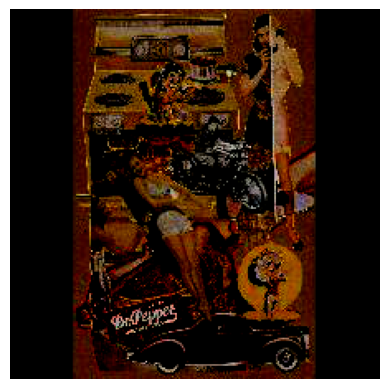

Top 3 similar images to the new point are: 1917      00206-venus1.jpg
3181    36018-orator15.jpg
1043    36018-orator15.jpg
Name: IMAGE_FILE, dtype: object
Image found: ./SemArt/all_image/Images\00206-venus1.jpg


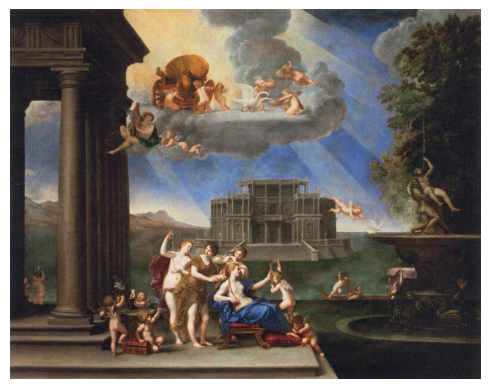

Image found: ./SemArt/all_image/Images\36018-orator15.jpg


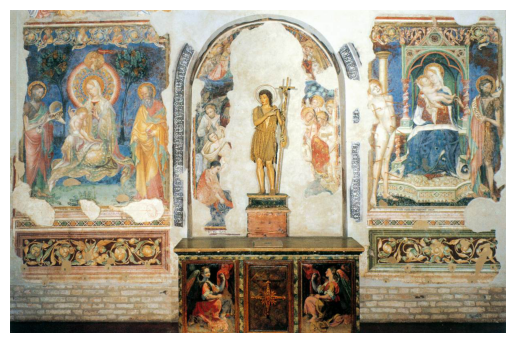

Image found: ./SemArt/all_image/Images\36018-orator15.jpg


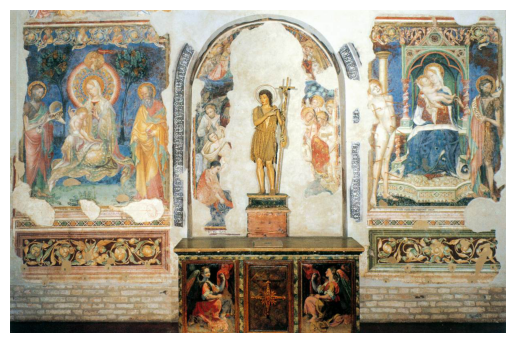

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================1=================
Image Input to johan-hendrik-weissenbruch_road-near-noorden.jpg


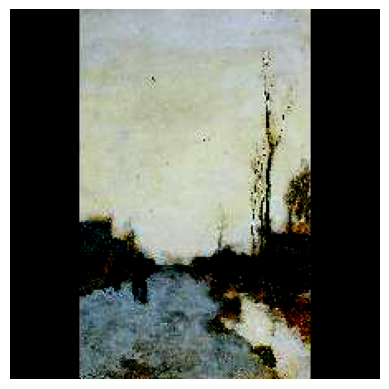

Top 3 similar images to the new point are: 1266    37467-woodland.jpg
654     23780-whaleoil.jpg
2792    23780-whaleoil.jpg
Name: IMAGE_FILE, dtype: object
Image found: ./SemArt/all_image/Images\37467-woodland.jpg


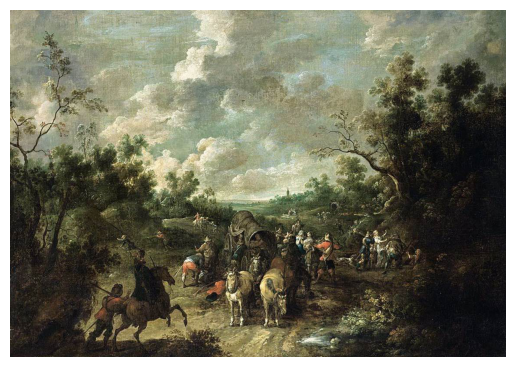

Image found: ./SemArt/all_image/Images\23780-whaleoil.jpg


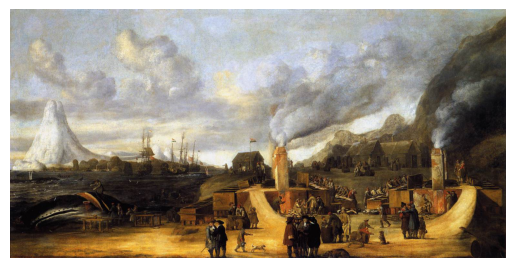

Image found: ./SemArt/all_image/Images\23780-whaleoil.jpg


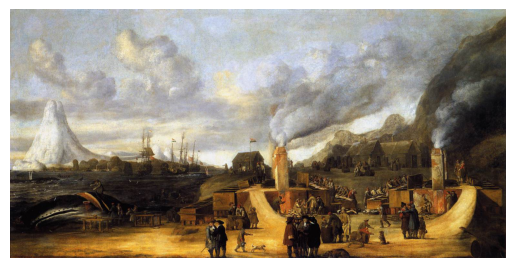

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================2=================
Image Input to agnolo-bronzino_portrait-of-lorenzo-lenzi.jpg


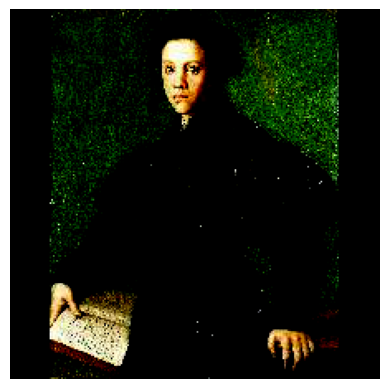

Top 3 similar images to the new point are: 3149    00813-marco_p3.jpg
1011    00813-marco_p3.jpg
454     08579-3victor5.jpg
Name: IMAGE_FILE, dtype: object
Image found: ./SemArt/all_image/Images\00813-marco_p3.jpg


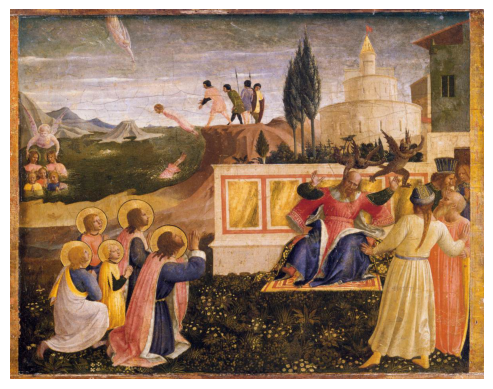

Image found: ./SemArt/all_image/Images\00813-marco_p3.jpg


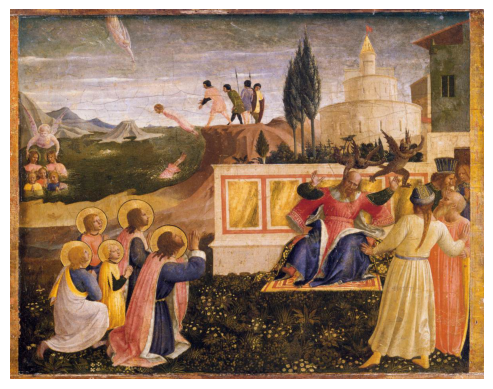

Image found: ./SemArt/all_image/Images\08579-3victor5.jpg


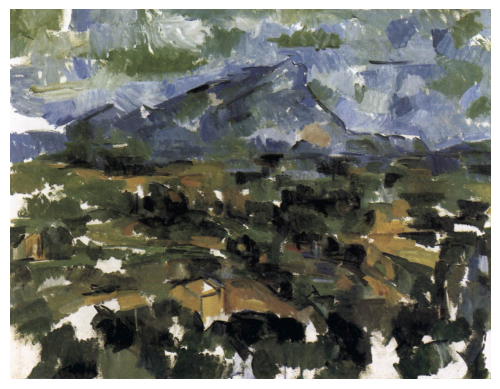

In [28]:
counter = 0
# assuming we only input one Image where batch size  = 1
for images, labels, filenames, sublabels in test_loader_wiki:
    print(f"================{counter}=================")
    print(f"Image Input to {filenames[0]}")
    # Rearrange the axes from (1, 3, 224, 224) to (224, 224, 3)
    img = np.transpose(images, (0, 2, 3, 1)).squeeze(0)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Optionally remove the axis
    plt.show()

    emb = encode_image(images,model_unet)
    top_3_filenames, info = get_top_similar_file(emb)
    for fn in top_3_filenames:
        find_and_display_image(fn)
    if counter == 2:
        break
    counter +=1